In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Activation
from tensorflow.keras.layers import AveragePooling2D, Input, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio

In [11]:
import scipy.io
import numpy as np
import os
from tensorflow.keras.utils import to_categorical

def load_data_from_mat(path):
    train_data = []
    train_labels = []
    test_data = []
    test_labels = []

    for file in os.listdir(path):
        if file.startswith('train_'):
            mat = scipy.io.loadmat(os.path.join(path, file))
            train_data.append(mat[list(mat.keys())[-2]])  # Assuming data is the second last key
            train_labels.append(mat[list(mat.keys())[-1]])  # Assuming label is the last key
        elif file.startswith('test_'):
            mat = scipy.io.loadmat(os.path.join(path, file))
            test_data.append(mat[list(mat.keys())[-2]])
            test_labels.append(mat[list(mat.keys())[-1]])

    # Concatenate all data and labels respectively
    train_data = np.concatenate(train_data, axis=0)
    train_labels = np.concatenate(train_labels, axis=0)
    test_data = np.concatenate(test_data, axis=0)
    test_labels = np.concatenate(test_labels, axis=0)

    # Normalize data
    train_data = train_data.astype('float32') / 255
    test_data = test_data.astype('float32') / 255

    # Convert labels to categorical (one-hot encoding)
    train_labels = to_categorical(train_labels, 10)
    test_labels = to_categorical(test_labels, 10)

    return train_data, train_labels, test_data, test_labels

# 调用函数加载数据
path = '/Users/fuyao/Documents/GitHub/DL-based-RF-Fingerprints-Recognition/database/'
train_data, train_labels, test_data, test_labels = load_data_from_mat(path)


print('Train data shape:', train_data.shape)
print('Train labels shape:', train_labels.shape)
print('Test data shape:', test_data.shape)
print('Test labels shape:', test_labels.shape)


Train data shape: (126000, 3072)
Train labels shape: (126000, 10)
Test data shape: (14000, 3072)
Test labels shape: (14000, 10)


In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models

def build_resnet_model(input_shape, num_classes):
    base_model = ResNet50(weights=None, include_top=False, input_shape=input_shape)

    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    predictions = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=base_model.input, outputs=predictions)
    return model

# 注意：根据你的数据调整input_shape
model = build_resnet_model(input_shape=(32, 32, 3), num_classes=10)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

In [14]:
train_data_reshaped = train_data.reshape((-1, 32, 32, 3))
test_data_reshaped = test_data.reshape((-1, 32, 32, 3))


In [18]:
import numpy as np

# 假设 train_data_reshaped 和 train_labels 是你的完整训练数据和标签

sample_size = 18000  # 选择一个适合你计算资源的样本大小
indices = np.random.choice(range(len(train_data_reshaped)), sample_size, replace=False)

train_data_sample = train_data_reshaped[indices]
train_labels_sample = train_labels[indices]

# 重新构建模型
model = build_resnet_model(input_shape=(32, 32, 3), num_classes=10)

# 重新编译模型
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# 然后使用这个更小的数据集进行训练
history = model.fit(train_data_sample, train_labels_sample, validation_split=0.1, epochs=10, batch_size=32)


Epoch 1/10
507/507 ━━━━━━━━━━━━━━━━━━━━ 169s 309ms/step - accuracy: 0.3683 - loss: 1.8329 - val_accuracy: 0.0989 - val_loss: 15.0551
Epoch 2/10
507/507 ━━━━━━━━━━━━━━━━━━━━ 168s 331ms/step - accuracy: 0.5922 - loss: 0.9318 - val_accuracy: 0.2344 - val_loss: 5.1865
Epoch 3/10
507/507 ━━━━━━━━━━━━━━━━━━━━ 158s 311ms/step - accuracy: 0.6789 - loss: 0.7366 - val_accuracy: 0.6339 - val_loss: 0.9888
Epoch 4/10
507/507 ━━━━━━━━━━━━━━━━━━━━ 156s 308ms/step - accuracy: 0.7355 - loss: 0.5958 - val_accuracy: 0.3978 - val_loss: 5.3187
Epoch 5/10
507/507 ━━━━━━━━━━━━━━━━━━━━ 159s 313ms/step - accuracy: 0.7039 - loss: 0.6537 - val_accuracy: 0.5400 - val_loss: 7.4377
Epoch 6/10
507/507 ━━━━━━━━━━━━━━━━━━━━ 161s 318ms/step - accuracy: 0.7628 - loss: 0.5376 - val_accuracy: 0.7733 - val_loss: 0.4457
Epoch 7/10
507/507 ━━━━━━━━━━━━━━━━━━━━ 157s 309ms/step - accuracy: 0.7710 - loss: 0.4854 - val_accuracy: 0.3956 - val_loss: 2.3148
Epoch 8/10
507/507 ━━━━━━━━━━━━━━━━━━━━ 155s 305ms/step - accuracy: 0.7736 

In [57]:
model.save('/Users/fuyao/Documents/GitHub/DL-based-RF-Fingerprints-Recognition/model/resNet0327-1.h5')  # HDF5文件
loaded_model = tf.keras.models.load_model('/Users/fuyao/Documents/GitHub/DL-based-RF-Fingerprints-Recognition/model/resNet0327-1.h5')

In [58]:
# 评估模型在测试集上的性能
test_loss, test_acc = loaded_model.evaluate(test_data_reshaped, test_labels, verbose=2)

print(f'测试集损失: {test_loss}')
print(f'测试集准确率: {test_acc}')


63/63 - 3s - 54ms/step - accuracy: 0.3300 - loss: 33.5610
测试集损失: 33.56097412109375
测试集准确率: 0.33000001311302185


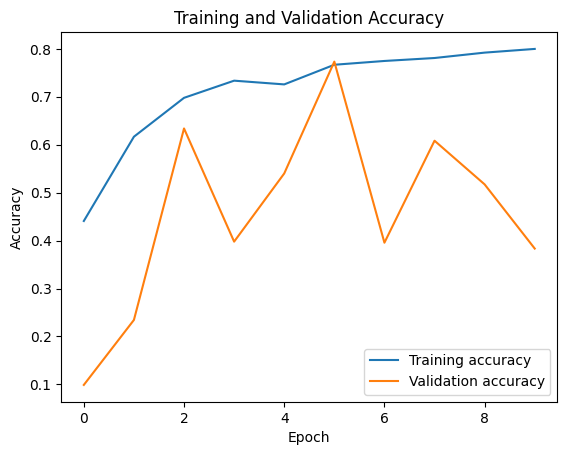

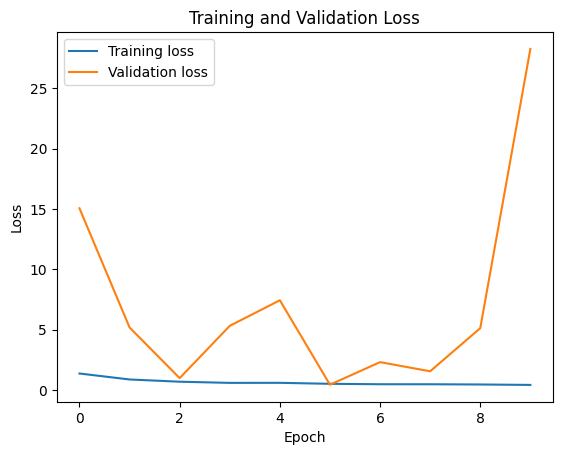

In [21]:
# 可视化训练过程
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

63/63 - 2s - 39ms/step - accuracy: 0.3995 - loss: 25.4422

Test accuracy: 0.3995000123977661
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       200
           1       1.00      0.99      0.99       200
           2       0.00      0.00      0.00       200
           3       0.25      1.00      0.40       200
           4       1.00      1.00      1.00       200
           5       0.33      1.00      0.50       200
           6       0.00      0.00      0.00       200
           7       1.00      0.01      0.01       200
           8       0.00      0.00      0.00       200
           9       0.00      0.00      0.00       200

    accuracy                           0.40      2000
   macro avg       0.36      0.40      0.29      2000
weighted avg       0.36      0.40      0.29      2000



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

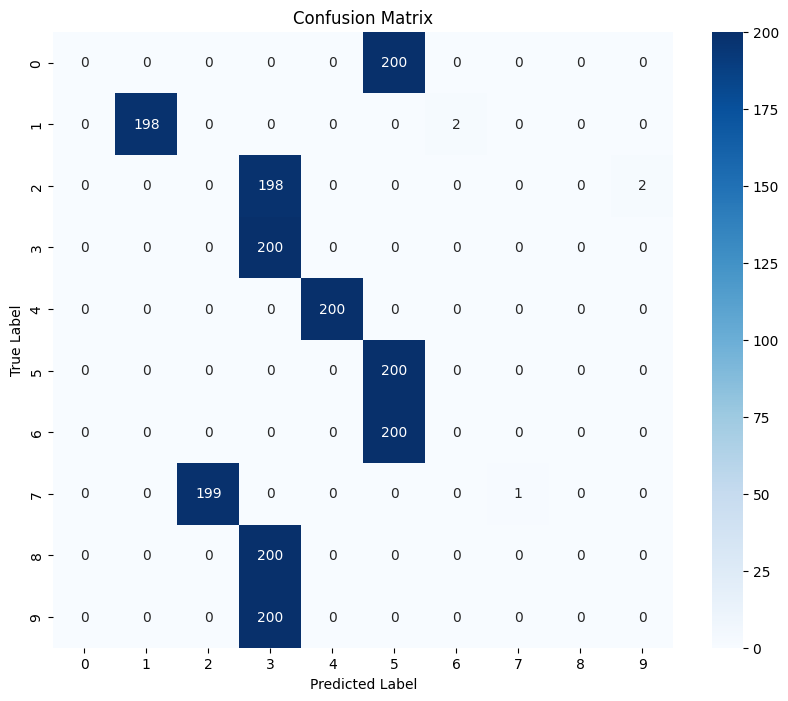

In [61]:
import scipy.io
import numpy as np
import os
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix


def load_data_from_mat(path,dBnumber):
    train_data = []
    train_labels = []
    test_data = []
    test_labels = []

    for file in os.listdir(path):
        if file.startswith(f'train_{dBnumber}.mat'):
            mat = scipy.io.loadmat(os.path.join(path, file))
            train_data.append(mat[list(mat.keys())[-2]])  # Assuming data is the second last key
            train_labels.append(mat[list(mat.keys())[-1]])  # Assuming label is the last key
        elif file.startswith(f'test_{dBnumber}.mat'):
            mat = scipy.io.loadmat(os.path.join(path, file))
            test_data.append(mat[list(mat.keys())[-2]])
            test_labels.append(mat[list(mat.keys())[-1]])

    # Concatenate all data and labels respectively
    # train_data = np.array(train_data)
    # train_labels = np.array(train_labels)
    # test_data = np.array(test_data)
    # test_labels = np.array(test_labels)
    train_data = np.concatenate(train_data, axis=0)
    train_labels = np.concatenate(train_labels, axis=0)
    test_data = np.concatenate(test_data, axis=0)
    test_labels = np.concatenate(test_labels, axis=0)
    # print(test_data.shape, test_labels.shape)

    # Normalize data
    train_data = train_data.astype('float32') / 255
    test_data = test_data.astype('float32') / 255

    # Convert labels to categorical (one-hot encoding)
    train_labels = to_categorical(train_labels, 10)
    test_labels = to_categorical(test_labels, 10)

    return train_data, train_labels, test_data, test_labels

# 调用函数加载数据
dBnumber = 20
path = '/Users/fuyao/Documents/GitHub/DL-based-RF-Fingerprints-Recognition/database/'
train_data, train_labels, test_data, test_labels = load_data_from_mat(path,dBnumber)

train_data_reshaped = train_data.reshape((-1, 32, 32, 3))
test_data_reshaped = test_data.reshape((-1, 32, 32, 3))

# 确保在这里使用测试数据和测试标签
test_loss, test_acc = loaded_model.evaluate(test_data_reshaped, test_labels, verbose=2)
print('\nTest accuracy:', test_acc)

# 预测测试数据集
predictions = loaded_model.predict(test_data_reshaped)
predicted_classes = np.argmax(predictions, axis=1)

# 计算并显示分类报告
report = classification_report(test_labels.argmax(axis=1), predicted_classes, target_names=[str(i) for i in range(10)])
print(report)

# 计算并绘制混淆矩阵
conf_matrix = confusion_matrix(test_labels.argmax(axis=1), predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


63/63 - 2s - 39ms/step - accuracy: 0.3995 - loss: 25.4422

Test accuracy: 0.3995000123977661
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       200
           1       1.00      0.99      0.99       200
           2       0.00      0.00      0.00       200
           3       0.25      1.00      0.40       200
           4       1.00      1.00      1.00       200
           5       0.33      1.00      0.50       200
           6       0.00      0.00      0.00       200
           7       1.00      0.01      0.01       200
           8       0.00      0.00      0.00       200
           9       0.00      0.00      0.00       200

    accuracy                           0.40      2000
   macro avg       0.36      0.40      0.29      2000
weighted avg       0.36      0.40      0.29      2000



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

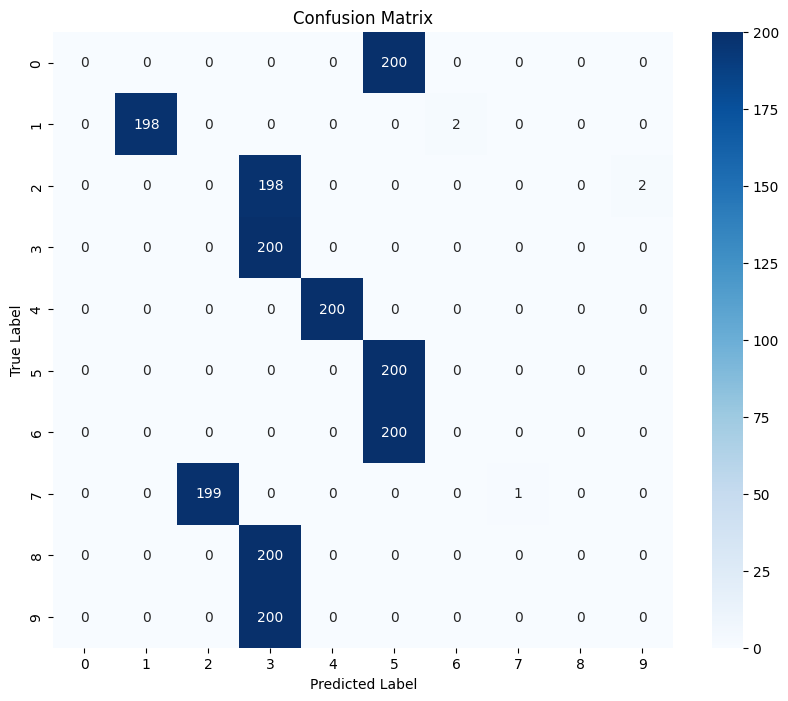

In [62]:
import scipy.io
import numpy as np
import os
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix


def load_data_from_mat(path,dBnumber):
    train_data = []
    train_labels = []
    test_data = []
    test_labels = []

    for file in os.listdir(path):
        if file.startswith(f'train_{dBnumber}.mat'):
            mat = scipy.io.loadmat(os.path.join(path, file))
            train_data.append(mat[list(mat.keys())[-2]])  # Assuming data is the second last key
            train_labels.append(mat[list(mat.keys())[-1]])  # Assuming label is the last key
        elif file.startswith(f'test_{dBnumber}.mat'):
            mat = scipy.io.loadmat(os.path.join(path, file))
            test_data.append(mat[list(mat.keys())[-2]])
            test_labels.append(mat[list(mat.keys())[-1]])

    # Concatenate all data and labels respectively
    # train_data = np.array(train_data)
    # train_labels = np.array(train_labels)
    # test_data = np.array(test_data)
    # test_labels = np.array(test_labels)
    train_data = np.concatenate(train_data, axis=0)
    train_labels = np.concatenate(train_labels, axis=0)
    test_data = np.concatenate(test_data, axis=0)
    test_labels = np.concatenate(test_labels, axis=0)
    # print(test_data.shape, test_labels.shape)

    # Normalize data
    train_data = train_data.astype('float32') / 255
    test_data = test_data.astype('float32') / 255

    # Convert labels to categorical (one-hot encoding)
    train_labels = to_categorical(train_labels, 10)
    test_labels = to_categorical(test_labels, 10)

    return train_data, train_labels, test_data, test_labels

# 调用函数加载数据
dBnumber = 20
path = '/Users/fuyao/Documents/GitHub/DL-based-RF-Fingerprints-Recognition/database/'
train_data, train_labels, test_data, test_labels = load_data_from_mat(path,dBnumber)

train_data_reshaped = train_data.reshape((-1, 32, 32, 3))
test_data_reshaped = test_data.reshape((-1, 32, 32, 3))

# 确保在这里使用测试数据和测试标签
test_loss, test_acc = loaded_model.evaluate(test_data_reshaped, test_labels, verbose=2)
print('\nTest accuracy:', test_acc)

# 预测测试数据集
predictions = loaded_model.predict(test_data_reshaped)
predicted_classes = np.argmax(predictions, axis=1)

# 计算并显示分类报告
report = classification_report(test_labels.argmax(axis=1), predicted_classes, target_names=[str(i) for i in range(10)])
print(report)

# 计算并绘制混淆矩阵
conf_matrix = confusion_matrix(test_labels.argmax(axis=1), predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
